In [2]:
from pvlib import pvsystem, singlediode
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math

from scipy.constants import e as qe, k as kB

In [3]:
# For simplicity, use cell temperature of 25C for all calculations.
# kB is J/K, qe is C=J/V
# kB * T / qe -> V
Vth = kB * (273.15+25) / qe

cell_parameters = {
    'I_L_ref': 8.24,
    'I_o_ref': 2.36e-9,
    'R_sh_ref': 1000,
      'a_ref': 1.3*Vth,
  'R_s': 0.00181,
    'alpha_sc': 0.0042,
    'breakdown_factor': 2e-3,
    'breakdown_exp': 3,
    'breakdown_voltage': -15,
}

In [4]:
def simulate_full_curves(parameters, Geffs, Tcell, ivcurve_pnts=1000):
    """
    Use De Soto and Bishop to simulate a full IV curve with both
    forward and reverse bias regions.
    """
    # adjust the reference parameters according to the operating
    # conditions using the De Soto model:
    curves = []
    for Geff in Geffs:
        sde_args = pvsystem.calcparams_desoto(
            Geff,
            Tcell,
            alpha_sc=parameters['alpha_sc'],
            a_ref=parameters['a_ref'],
            I_L_ref=parameters['I_L_ref'],
            I_o_ref=parameters['I_o_ref'],
            R_sh_ref=parameters['R_sh_ref'],
            R_s=parameters['R_s'],
        )
        # sde_args has values:
        # (photocurrent, saturation_current, resistance_series,
        # resistance_shunt, nNsVth)

        # Use Bishop's method to calculate points on the IV curve with V ranging
        # from the reverse breakdown voltage to open circuit
        kwargs = {
            'breakdown_factor': parameters['breakdown_factor'],
            'breakdown_exp': parameters['breakdown_exp'],
            'breakdown_voltage': parameters['breakdown_voltage'],
        }
        v_oc = singlediode.bishop88_v_from_i(
            0.0, *sde_args, **kwargs
        )
        # ideally would use some intelligent log-spacing to concentrate points
        # around the forward- and reverse-bias knees, but this is good enough:
        vd = np.linspace(0.99*kwargs['breakdown_voltage'], v_oc, ivcurve_pnts)

        ivcurve_i, ivcurve_v, _ = singlediode.bishop88(vd, *sde_args, **kwargs)
        curves.append(pd.DataFrame({
            'i': ivcurve_i,
            'v': ivcurve_v,
        }))
    
    return curves

In [5]:
# https://www.microsemi.com/document-portal/doc_view/125066-rf01055-datasheet

def bypass_diode():
    i_s = 0.00012
    t = 273.15 + 25
    v = np.linspace(0,1,1000)

    n = 1.446554

    v_t = kB * t / qe

    i = i_s * (np.exp(v/(v_t * n)) - 1)
    return pd.DataFrame({'i': i, 'v': -v})


sk_diode = bypass_diode()

#ax = plot_curves([sk_diode, cell_curve_full_sun], labels=['schottky diode', 'cell full sun'], title='IV curves')

In [6]:
def plot_curves(dfs, labels, title):
    """plot the forward- and reverse-bias portions of an IV curve"""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
    for df, label in zip(dfs, labels):
        df.plot('v', 'i', label=label, ax=axes[0])
        df.plot('v', 'i', label=label, ax=axes[1])
        axes[0].set_xlim(right=0)
        axes[0].set_ylim([0, 25])
        axes[1].set_xlim([0, df['v'].max()*1.5])
    axes[0].set_ylabel('current [A]')
    axes[0].set_xlabel('voltage [V]')
    axes[1].set_xlabel('voltage [V]')
    fig.suptitle(title)
    fig.tight_layout()
    return axes

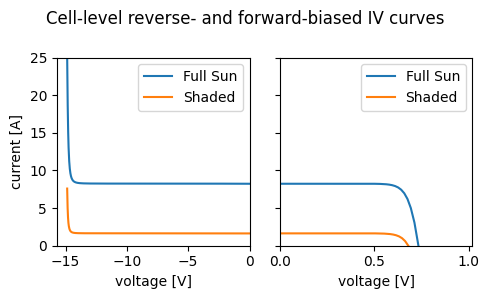

In [7]:
cell_curve_full_sun = simulate_full_curves(cell_parameters, Geffs=[1000], Tcell=25)[0]
cell_curve_shaded = simulate_full_curves(cell_parameters, Geffs=[200], Tcell=25)[0]
ax = plot_curves([cell_curve_full_sun, cell_curve_shaded],
                 labels=['Full Sun', 'Shaded'],
                 title='Cell-level reverse- and forward-biased IV curves')

In [8]:
def interpolate_v(df, i):
    """convenience wrapper around scipy.interpolate.interp1d"""
    f_interp = interp1d(np.flipud(df['i']), np.flipud(df['v']), kind='linear',
                        fill_value='extrapolate')
    return f_interp(i)

In [20]:
def interpolate_i(df, v):
    """convenience wrapper around scipy.interpolate.interp1d"""
    f_interp = interp1d(df['v'], df['i'], kind='linear',
                        fill_value='extrapolate')
    return f_interp(v)

In [33]:
def assemble_serial(curves):
    i_min = 0
    i_max = 0

    for curve in curves:
        i_min = min(i_min, curve['i'].min())
        i_max = max(i_min, curve['i'].max())

    i_max = min(i_max, 25)

    i = np.linspace(i_min, i_max, 1000)

    v = 0
    
    for curve in curves:
        v_diode = interpolate_v(curve, i)
        v += v_diode
    return pd.DataFrame({'i': i, 'v': v})

In [42]:
def assemble_parallel(curves):
    v_min = 0
    v_max = 0

    for curve in curves:
        v_min = min(v_min, curve['v'].min())
        v_max = max(v_max, curve['v'].max())
        
    v_min = max(v_min, -5)

    v = np.linspace(v_min, v_max, 1000)

    i = 0
    
    for curve in curves:
        i_diode = interpolate_i(curve, v)
        i += i_diode
    
    return pd.DataFrame({'i': i, 'v': v})

In [12]:
def arr_to_module(arr):
    rotated = np.flip(np.rot90(arr), axis=0)
    combined = np.concatenate((rotated[::2], np.flip(rotated[1::2], axis=1)), axis=1)
    return combined
    

In [13]:
test_arr = np.vander((1, 2, 3, 4, 5), 6)
print(test_arr)
print(arr_to_module(test_arr))

[[   1    1    1    1    1    1]
 [  32   16    8    4    2    1]
 [ 243   81   27    9    3    1]
 [1024  256   64   16    4    1]
 [3125  625  125   25    5    1]]
[[   1   32  243 1024 3125  625  256   81   16    1]
 [   1    8   27   64  125   25   16    9    4    1]
 [   1    2    3    4    5    1    1    1    1    1]]


In [14]:
def simulate_module_test(cell_parameters, poa_direct, poa_diffuse, Tcell,
                    shaded_fraction, cells_per_string=24, strings=4):
    """
    Simulate the IV curve for a partially shaded module.
    The shade is assumed to be coming up from the bottom of the module when in
    portrait orientation, so it affects all substrings equally.
    For simplicity, cell temperature is assumed to be uniform across the
    module, regardless of variation in cell-level illumination.
    Substrings are assumed to be "down and back", so the number of cells per
    string is divided between two columns of cells.
    """
    # find the number of cells per column that are in full shadow
    nrow = cells_per_string // 2
    nrow_full_shade = int(shaded_fraction * nrow)
    # find the fraction of shade in the border row
    partial_shade_fraction = 1 - (shaded_fraction * nrow - nrow_full_shade)

    df_lit = simulate_full_curves(
        cell_parameters,
        [poa_diffuse + poa_direct],
        Tcell)[0]
    df_partial = simulate_full_curves(
        cell_parameters,
        [poa_diffuse + partial_shade_fraction * poa_direct],
        Tcell)[0]
    df_shaded = simulate_full_curves(
        cell_parameters,
        [poa_diffuse],
        Tcell)[0]
    # build a list of IV curves for a single column of cells (half a substring)
    include_partial_cell = (shaded_fraction < 1)
    half_substring_curves_shaded = (
        [df_lit] * (nrow - nrow_full_shade - 1)
        + ([df_partial] if include_partial_cell else [])  # noqa: W503
        + [df_shaded] * nrow_full_shade  # noqa: W503
    )
    
    half_substring_curves_lit = ([df_lit] * nrow)

    substring_curve_shaded = assemble_serial(half_substring_curves_shaded)
    substring_curve_shaded['v'] *= 2  # turn half strings into whole strings
    full_substring_curve_shaded = assemble_parallel([bypass_diode(), substring_curve_shaded])

    substring_curve_lit = assemble_serial(half_substring_curves_lit)
    substring_curve_lit['v'] *= 2
    full_substring_curve_lit = assemble_parallel([bypass_diode(), substring_curve_lit])  # turn half strings into whole strings
    full_substring_curve_lit['v'] *= (strings - 1)
    #full_substring_curve_lit = full_substring_curve_lit['v'].clip(lower=-0.5)

    # no need to interpolate since we're just scaling voltage directly:
    #print([2] + ([3] * (strings - 1)))
    substring_curve = assemble_serial([full_substring_curve_shaded, full_substring_curve_lit])
    #print(np.array([full_substring_curve_shaded, full_substring_curve_lit]).shape)
    return substring_curve

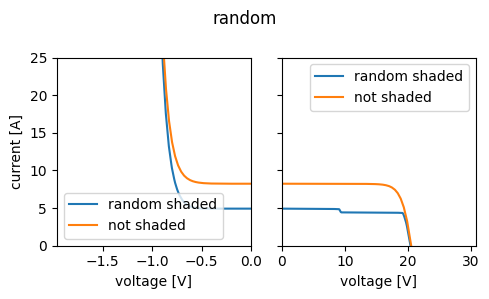

In [50]:
def simulate_module_shaded(shadow_arr, poa_direct=800, poa_diffuse=200, Tcell=25,):
    
    shadow_module = arr_to_module(shadow_arr)

    iv_strings = []
    for string in shadow_module:
        iv_strings.append(assemble_parallel([assemble_serial(simulate_full_curves(cell_parameters, string * poa_direct + poa_diffuse, Tcell)), bypass_diode()]))
        #iv_strings.append(assemble_serial(simulate_full_curves(cell_parameters, string * poa_direct + poa_diffuse, Tcell)))

    iv_module = assemble_serial(iv_strings)
    return iv_module
    



test = 1- np.random.random((7,4))**7
test2 = np.ones((7,4))

ax = plot_curves([simulate_module_shaded(test, 800, 200, 25), simulate_module_shaded(test2, 800, 200, 25)], labels=['random shaded', 'not shaded'], title='random')
    

-3.0274699246366486e-14
-3.0274699246366486e-14
-0.05764509828863035
-3.0274699246366486e-14
-3.0274699246366486e-14
-0.05764509828863035


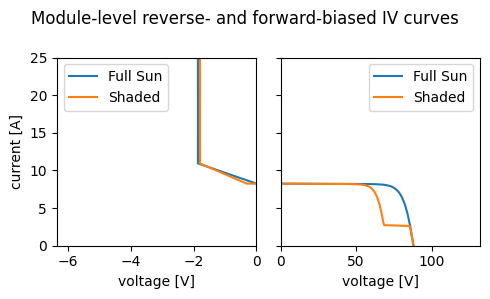

In [ ]:
kwargs = {
    'cell_parameters': cell_parameters,
    'poa_direct': 800,
    'poa_diffuse': 200,
    'Tcell': 25
}
module_curve_full_sun = simulate_module_test(shaded_fraction=0, **kwargs, strings=5)
module_curve_shaded = simulate_module_test(shaded_fraction=0.07, **kwargs, strings=5)
ax = plot_curves([module_curve_full_sun, module_curve_shaded],
                 labels=['Full Sun', 'Shaded'],
                 title='Module-level reverse- and forward-biased IV curves')

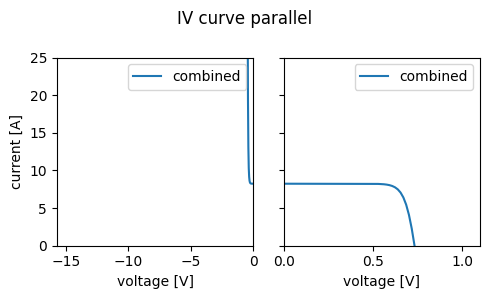

In [ ]:
combined_parallel = assemble_parallel([sk_diode, cell_curve_full_sun])

ax = plot_curves([combined_parallel], labels=['combined'], title='IV curve parallel')